# Laboratorio 3. Práctica 2 - DNN para clasificar imágenes
## Preparación de entorno
### Gonzalo de las Heras
### Jorge de la Fuente

#### Importar librerías de código

In [32]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from keras.constraints import maxnorm
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from matplotlib import pyplot as plt
from keras.models import load_model
from matplotlib.ticker import FuncFormatter
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from IPython.display import SVG
from keras.utils import plot_model
import keras.backend as K

import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import numpy
import matplotlib as mp
import pandas as pd

#### Variables globales

In [2]:
Clases = np.array(["Avión", "Coche", "Pájaro", "Gato", "Ciervo", "Perro", "Rana", "Caballo", "Barco", "Camión"])
Epochs = 25
Cargar_modelo_desde_fichero = True

#### Funciones auxiliares

In [3]:
""" 
Función para sacar una gráfica con los probabilidad de que una iamgen pertenezca a una clase.
Parámetros:
    - Datos: Vector de probabilidades.
"""
def GraficaPorcentajes(Datos):      
    
    N = 10
    men_means = Datos * 100
    ind = np.arange(N)
    width = 0.35

    posicion = np.argmax(Datos)
    
    print("Con un ", round(men_means[posicion], 1), "% es un/a ", Clases[posicion])
    
    fig, ax = plt.subplots()
    
    rects1 = ax.bar(ind, men_means, width, color='b')
    
    figure_title = "Predicción"

    plt.text(0.5, 1.15, figure_title,
             horizontalalignment='center',
             fontsize=20,
             transform = ax.transAxes)
    
    ax.set_ylabel('Probabilidad')
    ax.set_ylim([0,100])
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(("Avión", "Coche", "Pájaro", "Gato", "Ciervo","Perro","Rana","Caballo", "Barco", "Camión"))
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)

    plt.show()

In [4]:
""" 
Función para cargar los ficheros txt de las imágenes propuestas para la clasificación y transformarlas en arrays de tríos RGB.
Parámetros:
    - Dir: Dirección donde está alojado el fichero txt a cargar.
Devuelve:
    - Matriz RBG con los datos de la imagen.
    
(c) Gonzalo de las Heras y Jorge de la Fuente
"""
def CargarDatosClasificacion(Dir):
    datos = None
    matriz = None
    with open(Dir, 'r') as fichero:
        datos = fichero.read().replace('\n', '').replace('[', '').replace(']', '').replace(',,', ',')
    matriz = numpy.fromstring(datos, dtype=float, sep=',')    
    matriz = matriz.reshape(1, 32, 32, 3)
    matriz = matriz / 255
    return matriz

In [5]:
""" 
Función para predecir las imágenes propuestas almacenadas en ficheros externos.
Parámetros:
    - NumFicheros: Número de ficheros a cargar y predecir.
ATENCIÓN!!!
    - El formato del nombre de los ficheros debe de ser image(NÚMERO).txt
"""
def PredecirDatosExternos(NumFicheros, KerasModel):
    NumFicheros +=1
    for i in range (1, NumFicheros):
        print("==========================================================")
        print("IMAGEN:")
        matriz = CargarDatosClasificacion('images/image' + str(i) + '.txt')
        prediccion = KerasModel.predict(matriz)
        plt.figure(figsize=(1.5,1.5))
        plt.imshow(matriz[0])
        plt.show()
        print("--------")
        GraficaPorcentajes(prediccion.astype(float)[0])

In [6]:
""" 
Función para predecir las imágenes propuestas almacenadas en ficheros externos.
Parámetros:
    - NumFicheros: Número de ficheros a cargar y predecir.
ATENCIÓN!!!
    - El formato del nombre de los ficheros debe de ser image(NÚMERO).txt
Devuelve:
    - Modelo de keras de la red neuronal.
"""
def CrearModelo():   
    
    # padding="same -> zero padding.
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size = (3,3), padding="same", activation = "relu", input_shape=(32, 32, 3))) 
    model.add(Conv2D(32, (3, 3), padding="same", activation = "relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same", activation = "relu"))
    model.add(Conv2D(64, (3, 3), padding="same", activation = "relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # MLP
    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5)) #Dropout en MLP, recomendado por chollet.
    model.add(Dense(10, activation = "softmax"))

    model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"]) 
    
    return model

In [7]:
""" 
Funcion para entrenar un modelo de red neuronal pasado por parámetro y guardarla en un fichero.
Parámetros:
    - Model: Modelo de red neuronal a entrenar.
"""
def EntrenarModelo(KerasModel):
    
    print(Model.summary())

    # Parada prematura para evitar sobreentrenamiento, paciencia 3
    earlyStopping = EarlyStopping(monitor="val_loss", patience=3, verbose=0, mode="auto")

    # Entrenamiento del modelo
    KerasModel.fit(x_train, y_train, validation_split = 0.2, epochs=Epochs, batch_size=32, callbacks=[earlyStopping])

    # Evaluación del modelo
    scores = KerasModel.evaluate(x_test, y_test, verbose=0)
    
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    # Guardado en disco del modelo
    KerasModel.save("red_conv_cifar10.h5")

#### Programa principal

In [8]:
# Carga de datos 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("=====================================\n")
print("El shape del conjunto de x_train es: " , x_train.shape)
print("El shape del conjunto de y_train es: " , y_train.shape)

# Normalización de los colores
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

# Los datos de salida están en un número decimal, hay que categorizar los datos
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print("Ejemplo de datos de salida categorizados:" , y_train[0] , "\n")

# Calculamos el número de clases
num_clases = y_test.shape[1]

print("=====================================")


El shape del conjunto de x_train es:  (50000, 32, 32, 3)
El shape del conjunto de y_train es:  (50000, 1)
Ejemplo de datos de salida categorizados: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.] 



In [9]:
if Cargar_modelo_desde_fichero is False:
    Model = CrearModelo()
    Model = EntrenarModelo(Model)

Model = load_model("red_conv_cifar10.h5")

#### Predicción

IMAGEN:


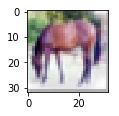

--------
Con un  83.2 % es un/a  Caballo


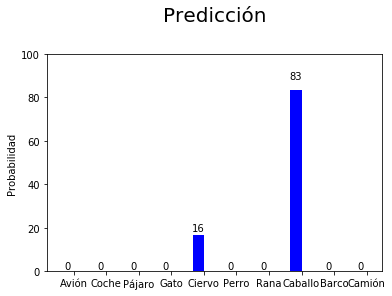

IMAGEN:


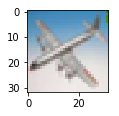

--------
Con un  99.8 % es un/a  Avión


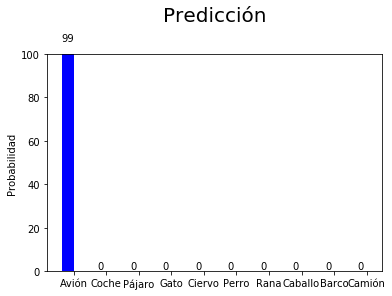

IMAGEN:


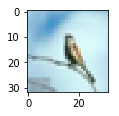

--------
Con un  97.4 % es un/a  Pájaro


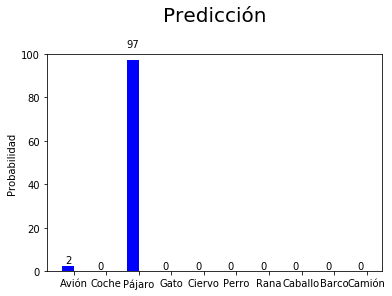

IMAGEN:


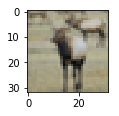

--------
Con un  86.0 % es un/a  Ciervo


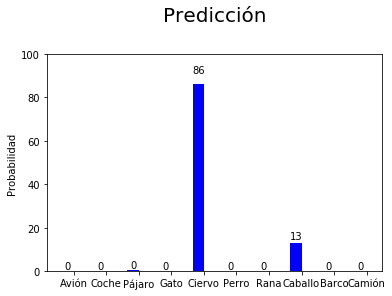

IMAGEN:


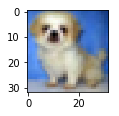

--------
Con un  97.7 % es un/a  Perro


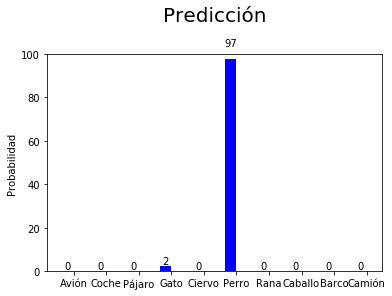

IMAGEN:


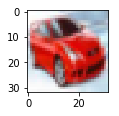

--------
Con un  100.0 % es un/a  Coche


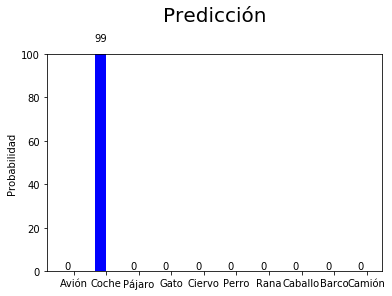

IMAGEN:


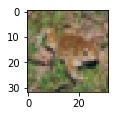

--------
Con un  100.0 % es un/a  Rana


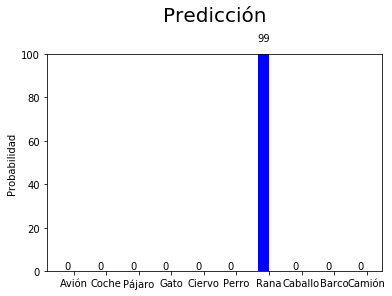

IMAGEN:


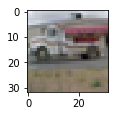

--------
Con un  92.6 % es un/a  Camión


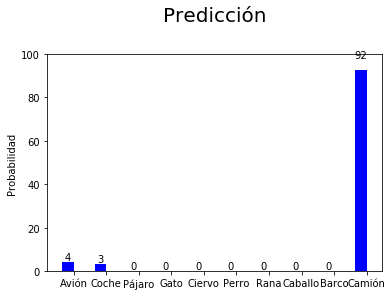

In [10]:
PredecirDatosExternos(8, Model)

In [11]:
plot_model(Model, to_file="modelo.png")

In [94]:
def get_output_layer(model, layer_name):
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

def visualize_class_activation_map(model_path, img_path, output_path):
        model = load_model(model_path)
        original_img = CargarDatosClasificacion(img_path)
        print(original_img.shape)
        width = 32
        height = 32
        _ = 3

        #Reshape to the network input shape (3, w, h).
        img = original_img
        #np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
        
        #Get the 512 input weights to the softmax.
        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = get_output_layer(model, "conv2d_24")
        get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
        [conv_outputs, predictions] = get_output([img])
        conv_outputs = conv_outputs[0, :, :, :]
        
        #print(conv_outputs)
        
        #plt.figure(figsize=(1.5,1.5))
        #plt.imshow(predictions[0])
        #plt.show()

        #Create the class activation map.
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
        target_class = 1
        print(cam.shape)
        for i, w in enumerate(class_weights[:, target_class]):
            #plt.figure(figsize=(1.5,1.5))
            #plt.imshow(cam)
            #plt.show()
            cam += w * conv_outputs[1, :, :]
            
        plt.figure(figsize=(1.5,1.5))
        plt.imshow(cam)
        plt.show()

(1, 32, 32, 3)
(16, 64)


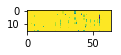

In [95]:
visualize_class_activation_map("red_conv_cifar10.h5",'images/image1.txt','aaa.png')

In [43]:
Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 8, 64)          0         
__________